In [2]:
!pip install --quiet --upgrade comet_ml
from comet_ml import Experiment
    
# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="0EKSrlH9OVngYfgQCrauwqLEt",
                        project_name="mri-interpretation", workspace="polina")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/polina/mri-interpretation/40a90ff1b18f40f490c285ea73417806



In [ ]:
# !pip install torchio

In [3]:
import numpy as np
import functools
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
# from torchsummary import summary
import os
import pathlib
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import torchio
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import *
import random
%matplotlib inline
import nilearn
from nilearn import plotting
from tqdm import tqdm

In [4]:
from data_old import HCP_MRI

In [5]:
 torch.cuda.is_available()

True

In [ ]:
!nvidia-smi

In [6]:
if torch.cuda.is_available():
  device = torch.device("cuda:5")
else:
  device = torch.device("cpu")

In [7]:
data_dir = pathlib.Path('/data/adni')

In [8]:
PATH_TO_MRI = '/data/HCP'
data_dir = pathlib.Path('/data/adni')
behavioral_path = os.path.join(data_dir / 'unrestricted_hcp_freesurfer.csv')
hcp_type = 'MPR1'

In [9]:
def plot_central_cuts(img, title="", t=None):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    param image: tensor or np array of shape (TxCxDxHxW) if t is not None
    """
    if t is not None:
        img = img[t]
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 6, 6))
    fig.suptitle(title)
    axes[0].imshow(img[0, img.shape[1] // 2, :, :])
    axes[1].imshow(img[0, :, img.shape[2] // 2, :])
    axes[2].imshow(img[0, :, :, img.shape[3] // 2])
    plt.show()
    
def get_absmax(dataset):
    absmax = 0.
    for (img, target) in dataset:
        img = torch.FloatTensor(img).to(device)
        absmax = max(absmax, img.abs().max().item())
        del img, target
    return absmax

def AbsMaxScale(img, absmax):
    return img / absmax

HCP absmax before normalization: 435.0126647949219
Dataset size: 1112
Labels distribution: (array([0, 1]), array([605, 507]))

Example:
Image shape: torch.Size([1, 206, 250, 220])
Type: <class 'torch.Tensor'>
Target: 1


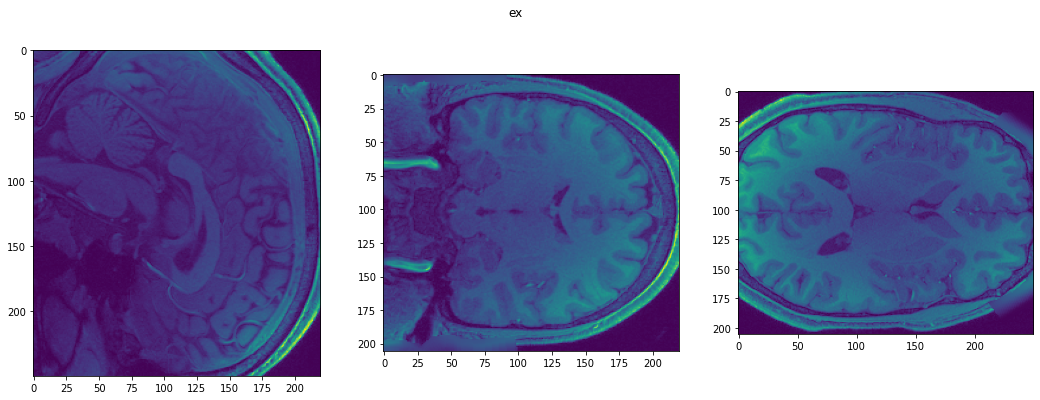

In [10]:
hcp_dataset = HCP_MRI(
    paths= PATH_TO_MRI,
    target_path= behavioral_path,
    load_online=True,
    hcp_type = hcp_type,
    coord_min=(25,30,50),
    img_shape=(206, 250, 220)
)
hcp_absmax = 435.0126647949219 # get_absmax(la5_dataset)
hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)

transform = Compose([
#     BrightnessContrast(),
#     GaussNoise(),
#     Rotate(),
    ToTensor(),
])
hcp_dataset.transform = transform
print("HCP absmax before normalization: {}".format(hcp_absmax))
print("Dataset size: {}".format(len(hcp_dataset)))
print("Labels distribution: {}\n".format(np.unique(hcp_dataset.labels, return_counts=True)))

print("Example:")
img, target = hcp_dataset[0]
print("Image shape: {}".format(img.shape))
print("Type: {}".format(type(img)))
print("Target: {}".format(target))
plot_central_cuts(img, title="ex", t = None)

In [11]:
X_train_ind, X_test_ind, y_train_ind, y_test_ind = train_test_split(np.arange(len(hcp_dataset)), hcp_dataset.labels, test_size=0.2, stratify=hcp_dataset.labels, random_state=42)
train_loader = torch_data.DataLoader(torch_data.Subset(hcp_dataset, X_train_ind),
                                          shuffle=True,
                                          batch_size=4)
val_loader = torch_data.DataLoader(torch_data.Subset(hcp_dataset, X_test_ind),
                                    shuffle=False,
                                    batch_size=2)

In [12]:
class MriNetGrad(nn.Module):
    def __init__(self, c):
        super(MriNetGrad, self).__init__()
        self.features = nn.Sequential( 
                nn.Conv3d(1, c, kernel_size=3),
                nn.BatchNorm3d(c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3),
                
                nn.Conv3d(c, 2*c, kernel_size=3),
                nn.BatchNorm3d(2*c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3),
                
                nn.Conv3d(2*c, 4*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(4*c),
                nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.MaxPool3d(kernel_size=3),
            nn.Flatten(),
            nn.Linear(in_features=43008, out_features=2), #4*c*5*5*5
        )
        self.gradients = None
        
  
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)
        h = x.register_hook(self.activations_hook)
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features(x)
    
torch.manual_seed(1)
np.random.seed(1)

c = 32
model = MriNetGrad(c)

In [13]:
if torch.cuda.is_available():
    device = torch.device("cuda:5")
else:
    device = torch.device("cpu")

if torch.cuda.device_count() > 1:
    d_ids= [5,7]
    print("Let's use", d_ids, "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model, device_ids=d_ids)

Let's use [5, 7] GPUs!


In [ ]:
model = model.to(device)
model.load_state_dict(torch.load('/home/checkpoints_full/best_acc_model_NetGradRandomiz_all_subject_bs42', map_location=device))
model.eval()

In [14]:
def get_accuracy(net, data_loader):
    net.eval()
    correct = 0
    for data, target in tqdm(data_loader):
        data = data.to(device,dtype=torch.float)
        target = target.to(device)

        out = net(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        del data, target
    accuracy = 100. * correct / len(data_loader.dataset)
    return accuracy.item()

In [18]:
get_accuracy(model, val_loader)

100%|██████████| 112/112 [02:23<00:00,  1.28s/it]


98.2062759399414

In [15]:
get_accuracy(model, train_loader)

  0%|          | 1/223 [00:08<29:51,  8.07s/it]


RuntimeError: Caught RuntimeError in replica 0 on device 1.
Original Traceback (most recent call last):
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/torch/nn/parallel/parallel_apply.py", line 61, in _worker
    output = module(*input, **kwargs)
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "<ipython-input-11-50e475210a3c>", line 31, in forward
    x = self.features(x)
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/torch/nn/modules/container.py", line 117, in forward
    input = module(input)
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/torch/nn/modules/batchnorm.py", line 136, in forward
    self.weight, self.bias, bn_training, exponential_average_factor, self.eps)
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/torch/nn/functional.py", line 2058, in batch_norm
    training, momentum, eps, torch.backends.cudnn.enabled
RuntimeError: CUDA out of memory. Tried to allocate 2.63 GiB (GPU 1; 15.90 GiB total capacity; 11.72 GiB already allocated; 2.57 GiB free; 11.80 GiB reserved in total by PyTorch)


In [15]:
# timing
from tqdm import tqdm

def get_metric(net, data_loader):
    net.eval()
    correct = 0
    true = []
    for data, target in tqdm(data_loader):
        data = data.to(device,dtype=torch.float)
        target = target.to(device)

        out = net(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        true.append(pred.data.cpu().numpy())
        correct += pred.eq(target.data).cpu().sum()
        del data, target, out, pred
    accuracy = 100. * correct / len(data_loader.dataset)
    true = np.concatenate(true)
    roc_auc = roc_auc_score(data_loader.dataset.labels, true)
    pr = precision_score(data_loader.dataset.labels,  true)
    rec = recall_score(data_loader.dataset.labels, true)

    return accuracy.item(), roc_auc, pr, rec

def get_loss(net, data_loader):
    net.eval()
    loss = 0 
    correct = 0
    for data, target in tqdm(data_loader):
        data = data.to(device, dtype=torch.float)
        target = target.to(device)
    
        out = net(data)
        loss += criterion(out, target).item()*len(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

        del data, target, out 
    accuracy = 100. * correct / len(data_loader.dataset)
    return loss / len(data_loader.dataset), accuracy.item()


def train(epochs, net, criterion, optimizer, train_loader, val_loader, scheduler=None, verbose=True, save=False, experiment= False):
    best_val_loss = 100000 #100_000
    best_val_acc = 0
    best_model = None
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    loss, acc = get_loss(net, train_loader)
    train_loss_list.append(loss)
    train_acc_list.append(acc)
    loss, acc = get_loss(net, val_loader)
    val_loss_list.append(loss)
    val_acc_list.append(acc)
    del loss, acc
    if verbose:
        print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(0, epochs, train_loss_list[-1], val_loss_list[-1]))

    net.to(device)
    for epoch in range(1, epochs+1):
        net.train()
        train_loss = 0
        train_correct = 0
        for X, y in train_loader:
            # Perform one step of minibatch stochastic gradient descent
            X, y = X.to(device, dtype=torch.float), y.to(device)
            optimizer.zero_grad()
#             print(type(X))
            out = net(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*len(X)
            pred = out.data.max(1)[1] # get the index of the max log-probability
            train_correct += pred.eq(y.data).cpu().sum()
            del X, y, out, loss #freeing gpu space
        accuracy = 100. * train_correct / len(train_loader.dataset)
        train_loss_list.append(train_loss/len(train_loader.dataset))
        train_acc_list.append(accuracy.item())
            
        
        # define NN evaluation, i.e. turn off dropouts, batchnorms, etc.
        loss, acc = get_loss(net, val_loader)
        val_loss_list.append(loss)
        val_acc_list.append(acc)
        
        if scheduler is not None:
            scheduler.step(val_acc_list[-1])

        if save and val_acc_list[-1] > best_val_acc:
            torch.save(net.state_dict(), CHECKPOINTS_DIR + 'best_acc_model_' + model_name)    
            best_val_acc = val_acc_list[-1]
            
        if save and val_loss_list[-1] < best_val_loss:
            torch.save(net.state_dict(), CHECKPOINTS_DIR + 'best_val_loss_model_' + model_name)
            best_val_loss = val_loss_list[-1]
            
        if save and epoch%5==0:
            torch.save(net.state_dict(), CHECKPOINTS_DIR + str(epoch) + '_epoch_model_' + model_name)
            
        freq = 1
        if verbose and epoch%freq==0:
            print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f} Acc: Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, train_loss_list[-1], val_loss_list[-1], train_acc_list[-1], val_acc_list[-1] ))
        if experiment:
                experiment.log_metric("train_loss", train_loss_list[-1])
                experiment.log_metric("validate_loss", val_loss_list[-1])
                experiment.log_metric("train_acc", train_acc_list[-1])
                experiment.log_metric("validate_acc", val_acc_list[-1])
                experiment.log_epoch_end(epoch)
    return train_loss_list, val_loss_list, train_acc_list, val_acc_list    

In [16]:
CHECKPOINTS_DIR =  '/home/No_preproc/'

In [20]:
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
# cross_vall_acc_list = []
j = 1
torch.manual_seed(82)
torch.cuda.manual_seed(82)
np.random.seed(82)
for X_train, X_test in skf.split(np.arange(len(hcp_dataset)), hcp_dataset.labels):
    print('Doing {} split'.format(j))
    j += 1
    hcp_dataset = HCP_MRI(
    paths= PATH_TO_MRI,
    target_path= behavioral_path,
    load_online=True,
    hcp_type = hcp_type,
    coord_min=(25,30,50),
    img_shape=(206, 250, 220)
    )
    hcp_absmax = 435.0126647949219 # get_absmax(la5_dataset)
    hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)

    transform = Compose([
    #     BrightnessContrast(),
    #     GaussNoise(),
    #     Rotate(),
        ToTensor(),
    ])
    hcp_dataset.transform = transform

    train_loader = torch_data.DataLoader(torch_data.Subset(hcp_dataset, X_train),
                                              shuffle=True,
                                              batch_size=4)
    val_loader = torch_data.DataLoader(torch_data.Subset(hcp_dataset, X_test),
                                        shuffle=False,
                                        batch_size=2)

    #     model = mri_model.MriNet(C).to(device)
#     criterion = nn.NLLLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
#     scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)
    c = 32
    model = MriNetGrad(c)
    if torch.cuda.device_count() > 1:
        d_ids= [5,7]
        print("Let's use", d_ids, "GPUs!")
        # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        model = nn.DataParallel(model, device_ids=d_ids)
        model.to(device)
    model_name = '_no_preproc_cv_{}'.format(j)
    experiment.set_name("Golden_3DCNN_no_preproc_cv_{}".format(j))
    
    torch.save(torch_data.Subset(hcp_dataset.mri_paths, X_train), CHECKPOINTS_DIR + 'train' +model_name)
    torch.save(torch_data.Subset(hcp_dataset.mri_paths, X_test), CHECKPOINTS_DIR + 'val' +model_name)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.3)
    criterion = nn.CrossEntropyLoss()
    EPOCHS = 30

    train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=True, experiment= experiment) 
#     _, _, _, _ = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, device, scheduler=scheduler, save=False, verbose=False) 
    cross_vall_acc_list.append(get_accuracy(model, val_loader))
    print(cross_vall_acc_list[-1])
print('Mean cross-validation accuracy (5-folds):', np.mean(cross_vall_acc_list))
print('Std cross-validation accuracy (5-folds):', np.std(cross_vall_acc_list, ddof=1))

Doing 1 split


  0%|          | 0/209 [00:00<?, ?it/s]

Let's use [5, 7] GPUs!


100%|██████████| 139/139 [05:06<00:00,  2.20s/it]


Epoch 00/30 || Loss:  Train 46.5110 | Validation 48.4603


100%|██████████| 139/139 [05:15<00:00,  2.27s/it]
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 01/30 || Loss:  Train 0.3285 | Validation 0.2152 Acc: Train 86.3309 | Validation 92.8058


100%|██████████| 139/139 [05:12<00:00,  2.25s/it]


Epoch 02/30 || Loss:  Train 0.1735 | Validation 0.2002 Acc: Train 94.3645 | Validation 93.8849


100%|██████████| 139/139 [05:17<00:00,  2.29s/it]


Epoch 03/30 || Loss:  Train 0.1666 | Validation 0.1963 Acc: Train 95.2038 | Validation 93.1655


100%|██████████| 139/139 [05:13<00:00,  2.25s/it]


Epoch 04/30 || Loss:  Train 0.1591 | Validation 0.1952 Acc: Train 95.5636 | Validation 92.4460


100%|██████████| 139/139 [05:12<00:00,  2.25s/it]


Epoch 05/30 || Loss:  Train 0.1514 | Validation 0.1807 Acc: Train 95.5636 | Validation 93.8849


100%|██████████| 139/139 [05:19<00:00,  2.30s/it]


Epoch 06/30 || Loss:  Train 0.1441 | Validation 0.1800 Acc: Train 95.9233 | Validation 93.1655


100%|██████████| 139/139 [05:06<00:00,  2.21s/it]


Epoch 07/30 || Loss:  Train 0.1364 | Validation 0.1739 Acc: Train 96.5228 | Validation 92.8058


100%|██████████| 139/139 [05:10<00:00,  2.24s/it]


Epoch 08/30 || Loss:  Train 0.1314 | Validation 0.1637 Acc: Train 96.5228 | Validation 93.5252


100%|██████████| 139/139 [05:11<00:00,  2.24s/it]


Epoch 09/30 || Loss:  Train 0.1255 | Validation 0.1612 Acc: Train 96.5228 | Validation 93.5252


100%|██████████| 139/139 [05:14<00:00,  2.26s/it]


Epoch 10/30 || Loss:  Train 0.1205 | Validation 0.1573 Acc: Train 97.0024 | Validation 93.8849


100%|██████████| 139/139 [05:12<00:00,  2.25s/it]


Epoch 11/30 || Loss:  Train 0.1139 | Validation 0.1473 Acc: Train 97.4820 | Validation 94.6043


100%|██████████| 139/139 [05:10<00:00,  2.23s/it]


Epoch 12/30 || Loss:  Train 0.1097 | Validation 0.1555 Acc: Train 97.4820 | Validation 93.8849


100%|██████████| 139/139 [05:08<00:00,  2.22s/it]


Epoch 13/30 || Loss:  Train 0.1055 | Validation 0.1356 Acc: Train 97.2422 | Validation 96.0432


100%|██████████| 139/139 [05:25<00:00,  2.34s/it]


Epoch 14/30 || Loss:  Train 0.1025 | Validation 0.1328 Acc: Train 97.3621 | Validation 96.7626


100%|██████████| 139/139 [05:17<00:00,  2.29s/it]


Epoch 15/30 || Loss:  Train 0.0970 | Validation 0.1278 Acc: Train 97.8417 | Validation 96.0432


100%|██████████| 139/139 [05:15<00:00,  2.27s/it]


Epoch 16/30 || Loss:  Train 0.0942 | Validation 0.1246 Acc: Train 97.8417 | Validation 96.0432


100%|██████████| 139/139 [03:58<00:00,  1.72s/it]


Epoch 17/30 || Loss:  Train 0.0910 | Validation 0.1215 Acc: Train 98.2014 | Validation 96.7626


100%|██████████| 139/139 [03:53<00:00,  1.68s/it]


Epoch 18/30 || Loss:  Train 0.0858 | Validation 0.1233 Acc: Train 98.0815 | Validation 96.0432


100%|██████████| 139/139 [03:51<00:00,  1.66s/it]


Epoch 19/30 || Loss:  Train 0.0820 | Validation 0.1181 Acc: Train 98.5611 | Validation 95.3237


100%|██████████| 139/139 [03:55<00:00,  1.70s/it]


Epoch 20/30 || Loss:  Train 0.0787 | Validation 0.1232 Acc: Train 98.4412 | Validation 95.3237


100%|██████████| 139/139 [03:48<00:00,  1.65s/it]


Epoch 21/30 || Loss:  Train 0.0772 | Validation 0.1147 Acc: Train 98.3213 | Validation 97.1223


100%|██████████| 139/139 [06:20<00:00,  2.74s/it]


Epoch 22/30 || Loss:  Train 0.0757 | Validation 0.1142 Acc: Train 98.6811 | Validation 96.4029


100%|██████████| 139/139 [03:27<00:00,  1.49s/it]


Epoch 23/30 || Loss:  Train 0.0717 | Validation 0.1110 Acc: Train 98.8010 | Validation 96.7626


100%|██████████| 139/139 [03:14<00:00,  1.40s/it]


Epoch 24/30 || Loss:  Train 0.0668 | Validation 0.1072 Acc: Train 99.0408 | Validation 97.1223


100%|██████████| 139/139 [03:13<00:00,  1.39s/it]


Epoch 25/30 || Loss:  Train 0.0679 | Validation 0.1024 Acc: Train 98.9209 | Validation 96.7626


100%|██████████| 139/139 [03:14<00:00,  1.40s/it]


Epoch 26/30 || Loss:  Train 0.0633 | Validation 0.0971 Acc: Train 98.9209 | Validation 97.1223


100%|██████████| 139/139 [03:12<00:00,  1.38s/it]


Epoch 27/30 || Loss:  Train 0.0616 | Validation 0.0997 Acc: Train 99.0408 | Validation 97.4820


100%|██████████| 139/139 [03:07<00:00,  1.35s/it]


Epoch 28/30 || Loss:  Train 0.0593 | Validation 0.0955 Acc: Train 99.1607 | Validation 97.1223


100%|██████████| 139/139 [03:05<00:00,  1.33s/it]


Epoch 29/30 || Loss:  Train 0.0581 | Validation 0.0950 Acc: Train 98.6811 | Validation 97.4820


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 30/30 || Loss:  Train 0.0546 | Validation 0.0913 Acc: Train 99.2806 | Validation 97.8417


100%|██████████| 139/139 [03:00<00:00,  1.30s/it]


97.84172821044922
Doing 2 split


  0%|          | 0/209 [00:00<?, ?it/s]

Let's use [5, 7] GPUs!


100%|██████████| 139/139 [03:10<00:00,  1.37s/it]


Epoch 00/30 || Loss:  Train 13.8249 | Validation 13.3873


100%|██████████| 139/139 [03:10<00:00,  1.37s/it]


Epoch 01/30 || Loss:  Train 0.3468 | Validation 0.1948 Acc: Train 87.6499 | Validation 93.8849


100%|██████████| 139/139 [03:04<00:00,  1.33s/it]


Epoch 02/30 || Loss:  Train 0.1891 | Validation 0.1901 Acc: Train 93.8849 | Validation 94.9640


100%|██████████| 139/139 [03:09<00:00,  1.36s/it]


Epoch 03/30 || Loss:  Train 0.1781 | Validation 0.1744 Acc: Train 94.8441 | Validation 94.6043


100%|██████████| 139/139 [05:21<00:00,  2.31s/it]


Epoch 04/30 || Loss:  Train 0.1678 | Validation 0.1788 Acc: Train 94.4844 | Validation 94.9640


100%|██████████| 139/139 [05:53<00:00,  2.55s/it]


Epoch 05/30 || Loss:  Train 0.1630 | Validation 0.1632 Acc: Train 95.2038 | Validation 94.6043


100%|██████████| 139/139 [07:00<00:00,  3.03s/it]


Epoch 06/30 || Loss:  Train 0.1523 | Validation 0.1625 Acc: Train 95.6835 | Validation 95.6835


100%|██████████| 139/139 [05:18<00:00,  2.29s/it]


Epoch 07/30 || Loss:  Train 0.1478 | Validation 0.1574 Acc: Train 95.8034 | Validation 95.3237


100%|██████████| 139/139 [05:16<00:00,  2.28s/it]


Epoch 08/30 || Loss:  Train 0.1414 | Validation 0.1510 Acc: Train 96.0432 | Validation 95.3237


100%|██████████| 139/139 [05:18<00:00,  2.29s/it]


Epoch 09/30 || Loss:  Train 0.1351 | Validation 0.1471 Acc: Train 96.8825 | Validation 95.3237


100%|██████████| 139/139 [05:16<00:00,  2.28s/it]


Epoch 10/30 || Loss:  Train 0.1292 | Validation 0.1408 Acc: Train 97.0024 | Validation 95.6835


100%|██████████| 139/139 [05:18<00:00,  2.29s/it]


Epoch 11/30 || Loss:  Train 0.1275 | Validation 0.1407 Acc: Train 97.3621 | Validation 96.4029


100%|██████████| 139/139 [05:16<00:00,  2.28s/it]


Epoch 12/30 || Loss:  Train 0.1186 | Validation 0.1315 Acc: Train 97.2422 | Validation 95.6835


100%|██████████| 139/139 [05:21<00:00,  2.31s/it]


Epoch 13/30 || Loss:  Train 0.1149 | Validation 0.1338 Acc: Train 97.1223 | Validation 96.4029


100%|██████████| 139/139 [05:13<00:00,  2.26s/it]


Epoch 14/30 || Loss:  Train 0.1095 | Validation 0.1296 Acc: Train 97.0024 | Validation 96.7626


100%|██████████| 139/139 [05:19<00:00,  2.30s/it]


Epoch 15/30 || Loss:  Train 0.1065 | Validation 0.1217 Acc: Train 97.2422 | Validation 96.0432


100%|██████████| 139/139 [05:35<00:00,  2.41s/it]


Epoch 16/30 || Loss:  Train 0.1040 | Validation 0.1236 Acc: Train 97.3621 | Validation 96.7626


100%|██████████| 139/139 [05:33<00:00,  2.40s/it]


Epoch 17/30 || Loss:  Train 0.0968 | Validation 0.1421 Acc: Train 97.4820 | Validation 94.9640


100%|██████████| 139/139 [05:20<00:00,  2.30s/it]


Epoch 18/30 || Loss:  Train 0.0971 | Validation 0.1295 Acc: Train 97.8417 | Validation 96.4029


100%|██████████| 139/139 [05:29<00:00,  2.37s/it]


Epoch 19/30 || Loss:  Train 0.0917 | Validation 0.1201 Acc: Train 98.0815 | Validation 96.7626


100%|██████████| 139/139 [05:27<00:00,  2.35s/it]


Epoch 20/30 || Loss:  Train 0.0870 | Validation 0.1131 Acc: Train 98.2014 | Validation 96.4029


100%|██████████| 139/139 [04:02<00:00,  1.75s/it]


Epoch 21/30 || Loss:  Train 0.0830 | Validation 0.1169 Acc: Train 98.4412 | Validation 96.7626


100%|██████████| 139/139 [03:59<00:00,  1.72s/it]


Epoch 22/30 || Loss:  Train 0.0819 | Validation 0.1023 Acc: Train 98.0815 | Validation 96.7626


100%|██████████| 139/139 [03:59<00:00,  1.72s/it]


Epoch 23/30 || Loss:  Train 0.0781 | Validation 0.1056 Acc: Train 98.3213 | Validation 96.7626


100%|██████████| 139/139 [03:59<00:00,  1.72s/it]


Epoch 24/30 || Loss:  Train 0.0754 | Validation 0.0995 Acc: Train 98.0815 | Validation 97.1223


100%|██████████| 139/139 [04:01<00:00,  1.74s/it]


Epoch 25/30 || Loss:  Train 0.0725 | Validation 0.1050 Acc: Train 98.8010 | Validation 97.1223


100%|██████████| 139/139 [03:58<00:00,  1.71s/it]


Epoch 26/30 || Loss:  Train 0.0710 | Validation 0.0968 Acc: Train 98.9209 | Validation 97.4820


100%|██████████| 139/139 [04:05<00:00,  1.77s/it]


Epoch 27/30 || Loss:  Train 0.0682 | Validation 0.0967 Acc: Train 98.9209 | Validation 97.4820


100%|██████████| 139/139 [03:53<00:00,  1.68s/it]


Epoch 28/30 || Loss:  Train 0.0657 | Validation 0.1023 Acc: Train 98.8010 | Validation 97.1223


100%|██████████| 139/139 [04:02<00:00,  1.74s/it]


Epoch 29/30 || Loss:  Train 0.0621 | Validation 0.0921 Acc: Train 99.2806 | Validation 97.8417


100%|██████████| 139/139 [04:27<00:00,  1.93s/it]


Epoch 30/30 || Loss:  Train 0.0606 | Validation 0.0933 Acc: Train 99.0408 | Validation 97.8417


100%|██████████| 139/139 [04:30<00:00,  1.95s/it]


97.84172821044922
Doing 3 split


  0%|          | 0/209 [00:00<?, ?it/s]

Let's use [5, 7] GPUs!


 31%|███       | 65/209 [04:17<09:29,  3.96s/it]


KeyboardInterrupt: 

In [ ]:
check = torch_data.Subset(hcp_dataset.mri_paths, X_test)

In [24]:
print(type(float(97.3094)))

<class 'float'>


In [25]:
cross_vall_acc_list.append(float(97.3094))

In [26]:
# cross_vall_acc_list.append(get_accuracy(model, val_loader))
# print(cross_vall_acc_list[-1])
print('Mean cross-validation accuracy (5-folds):', np.mean(cross_vall_acc_list))
print('Std cross-validation accuracy (5-folds):', np.std(cross_vall_acc_list, ddof=1))

Mean cross-validation accuracy (5-folds): 97.57556853637695
Std cross-validation accuracy (5-folds): 0.3073347190312767


In [27]:
for i in range(1,4):
    model = MriNetGrad(c)
    if torch.cuda.device_count() > 1:
        d_ids= [5,7]
        print("Let's use", d_ids, "GPUs!")
        # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        model = nn.DataParallel(model, device_ids=d_ids)
        model.to(device)
    model = model.to(device)
    model.load_state_dict(torch.load('/home/no_preproc/best_val_loss_model__no_preproc_cv_{}'.format(i), map_location=device))
    model.eval()


0
1
2
3


In [29]:
train_cv = []
train_cv.append(float(99.2806))
train_cv.append(float(99.0408))
train_cv.append(float(99.130))
print('Mean cross-validation accuracy (5-folds):', np.mean(train_cv))
print('Std cross-validation accuracy (5-folds):', np.std(train_cv, ddof=1))

Mean cross-validation accuracy (5-folds): 99.15046666666667
Std cross-validation accuracy (5-folds): 0.12120302526477561


In [ ]:
99.2806, 99.0408, 99.130